# Auxiliary Interval Predictor Demo

#### Import Statements

In [1]:
import sys
sys.path.append("../../")

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

In [4]:
from uq360.algorithms.auxiliary_interval_predictor import AuxiliaryIntervalPredictor
from uq360.metrics import picp, mpiw, compute_regression_metrics
from uq360.metrics import UncertaintyCharacteristicsCurve as ucc

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch

#### Load Boston Housing Prices Dataset

In [6]:
house_prices_dataset = datasets.load_boston()
house_prices_df = pd.DataFrame(house_prices_dataset['data'])
house_prices_df.columns = house_prices_dataset['feature_names']

all_features = ['RM','CRIM','PTRATIO', 'DIS']
X = house_prices_df[all_features].values
y = house_prices_dataset['target']

#### Train test split of the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Text(0.5, 1.0, 'Training data')

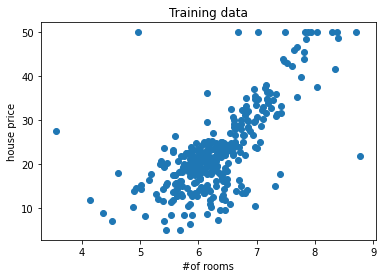

In [8]:
plt.scatter(X_train[:,0], y_train)
plt.xlabel('#of rooms')
plt.ylabel('house price')
plt.title('Training data')

In [9]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

### Train Auxiliary Interval Predictor Model

In [10]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
config = {"num_features": X_train.shape[1], "num_outputs": y_train.shape[1], "num_hidden": 50, "batch_size": 32,
                  "lr": 0.01, "num_main_iters": 50, "num_aux_iters": 5, "num_outer_iters": 5,
                  "lambda_noise": 0.001, "lambda_sharpness": 0.01, "lambda_match": 1.0, "calibration_alpha": 0.90}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
uq_model = AuxiliaryIntervalPredictor(model_type='mlp', config=config, device=device)

In [11]:
uq_model = uq_model.fit(X_train, y_train)

Iter: 0,  Epoch: 0, main_model_loss = 0.3544428957005342
Iter: 0,  Epoch: 1, main_model_loss = 0.22940429610510668
Iter: 0,  Epoch: 2, main_model_loss = 0.19649613151947656
Iter: 0,  Epoch: 3, main_model_loss = 0.16679944470524788
Iter: 0,  Epoch: 4, main_model_loss = 0.15240077363948026
Iter: 0,  Epoch: 5, main_model_loss = 0.1419771313667297
Iter: 0,  Epoch: 6, main_model_loss = 0.1355592173834642
Iter: 0,  Epoch: 7, main_model_loss = 0.13652148780723414
Iter: 0,  Epoch: 8, main_model_loss = 0.133726140173773
Iter: 0,  Epoch: 9, main_model_loss = 0.1324680078153809
Iter: 0,  Epoch: 10, main_model_loss = 0.12922447485228378
Iter: 0,  Epoch: 11, main_model_loss = 0.1281825260569652
Iter: 0,  Epoch: 12, main_model_loss = 0.12766601766149205
Iter: 0,  Epoch: 13, main_model_loss = 0.1261024835209052
Iter: 0,  Epoch: 14, main_model_loss = 0.12684153579175472
Iter: 0,  Epoch: 15, main_model_loss = 0.13935778010636565
Iter: 0,  Epoch: 16, main_model_loss = 0.17059730800489586
Iter: 0,  Epoch

Iter: 2,  Epoch: 38, main_model_loss = 0.5141347299019496
Iter: 2,  Epoch: 39, main_model_loss = 0.5405498358110586
Iter: 2,  Epoch: 40, main_model_loss = 0.5356462324659029
Iter: 2,  Epoch: 41, main_model_loss = 0.5206881413857142
Iter: 2,  Epoch: 42, main_model_loss = 0.5168578152855238
Iter: 2,  Epoch: 43, main_model_loss = 0.5107244079311688
Iter: 2,  Epoch: 44, main_model_loss = 0.5066191541651885
Iter: 2,  Epoch: 45, main_model_loss = 0.502133014301459
Iter: 2,  Epoch: 46, main_model_loss = 0.511499257137378
Iter: 2,  Epoch: 47, main_model_loss = 0.5070947147905827
Iter: 2,  Epoch: 48, main_model_loss = 0.5042511050899823
Iter: 2,  Epoch: 49, main_model_loss = 0.5279728720585505
Iter: 2,  Epoch: 0, aux_model_loss = 0.25513849655787146
Iter: 2,  Epoch: 1, aux_model_loss = 0.34786472966273624
Iter: 2,  Epoch: 2, aux_model_loss = 0.5180157894889513
Iter: 2,  Epoch: 3, aux_model_loss = 0.6192836488286654
Iter: 2,  Epoch: 4, aux_model_loss = 0.67908992121617
Iter: 3,  Epoch: 0, main_m

In [12]:
y_mean, y_lower, y_upper = uq_model.predict(X_test)
y_mean, y_lower, y_upper = scaler_y.inverse_transform(y_mean), scaler_y.inverse_transform(y_lower), scaler_y.inverse_transform(y_upper)
X_test = scaler_X.inverse_transform(X_test)

In [13]:
pred_dict = {'rooms': X_test[:,0],
             'y': y_test[:,0],
             'y_mean': y_mean[:,0],
             'y_upper': y_upper[:,0],
             'y_lower': y_lower[:,0]
            }

pred_df = pd.DataFrame(data=pred_dict)

pred_df_sorted = pred_df.sort_values(by='rooms')

Text(0.5, 1.0, 'Test data PICP: 0.95 MPIW: 18.40')

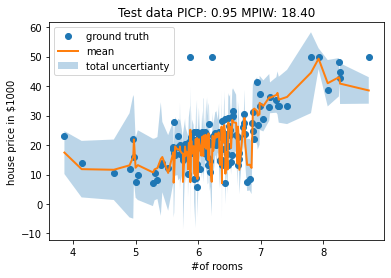

In [14]:
plt.plot(pred_df_sorted['rooms'], pred_df_sorted['y'], 'o', label='ground truth')
plt.plot(pred_df_sorted['rooms'], pred_df_sorted['y_mean'], '-', lw=2, label='mean')
plt.fill_between(pred_df_sorted['rooms'],
                         pred_df_sorted['y_upper'],
                         pred_df_sorted['y_lower'],
                         alpha=0.3, label='total uncertianty')
plt.legend()
plt.xlabel('#of rooms')
plt.ylabel('house price in $1000')
plt.title('Test data PICP: {:.2f} MPIW: {:.2f}'.format(
    picp(y_test, y_lower, y_upper),
    mpiw(y_lower, y_upper))      
         )

#### Let us now plot the AUUCC

In [15]:
def form_D(yhat, zhatl, zhatu):
    # a handy routine to format data as needed by the UCC fit() method
    D = np.zeros([yhat.shape[0],3])
    D[:, 0] = yhat
    D[:, 1] = zhatl
    D[:, 2] = zhatu
    return D

In [16]:
# form matrix for ucc:
X_for_ucc = form_D(y_mean[:,0], y_mean[:,0] - y_lower[:,0], y_upper[:,0] - y_mean[:,0])

# create an instance of ucc and fit data
u = ucc()
u.fit(X_for_ucc, y_test[:,0])

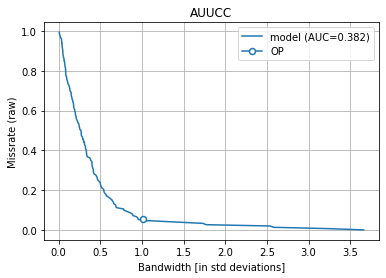

AUUCC is 0.38, OP = (0.11, 0.05)


In [17]:
u.set_coordinates(x_axis_name='bandwidth', y_axis_name='missrate', normalize=True)
auucc, op_info = u.plot_UCC(titlestr=('AUUCC'))
print("AUUCC is %.2f, OP = (%.2f, %.2f)" % (auucc, op_info[0]/op_info[2], op_info[1]))

In [18]:
compute_regression_metrics(y_test, y_mean, y_lower, y_upper)

{'rmse': 6.423551354032002,
 'nll': 3.238566733033707,
 'auucc_gain': -0.057818056692314,
 'picp': 0.9473684210526315,
 'mpiw': 18.40138,
 'r2': 0.5044524901328749}